In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import curve_fit
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy import optimize
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output
%matplotlib inline

In [2]:
# 2spot3 location 119,55 is the nice one

In [79]:
cd /Users/austinmcdonald/Desktop/test/cuthold/ca/Spot2/

/Users/austinmcdonald/Desktop/test/cuthold/ca/Spot2


In [80]:
files = os.listdir()
files = [x for x in files if x != '.DS_Store']
#files

In [81]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [82]:
eCoeff = 0.01160
eOffset= 1917
z=0
w=1

Shape = 221
xvs = np.arange(0,Shape)
neighborhood_size = 9
Row = int(4) # define the area to take around the spots
Col = int(4) # define the area to take around the spots

DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
Datatot = DataSub
fitts = []

AllPairs =[]
SpotInfo2 = []

ImageB = []
        

MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
for x in range(700,750):
    Images = np.array(Image.open(files[x]))
    Images = eCoeffM*(Images - eOffsetM)
    ImageFit = []
    for y in range(0,Shape):
        coefs = poly.polyfit(xvs,Images[y], 2) # fits 2nd order poly 
        ffit  = poly.polyval(xvs, coefs)
        ImageFit.append(ffit)
    MeanFit+=np.array(ImageFit)
MeanFit = MeanFit/50


for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM) - MeanFit
    DataSub += Images


data = DataSub

threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 


Images = None
ImageB = None
data   = None
Slices = None
labeled= None
num_objects=None

############################################################## 
Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>10 and XX<210 and YY>10 and YY<210:
        Xc.append(XX)
        Yc.append(YY)

for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM) - MeanFit
    Images[Images < 0] = 0 

    SpotInfoHolder = []

    for we in range(0,len(Xc)):
        Xindex = int(Xc[we])
        Yindex = int(Yc[we])

        spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot = spot1[2:7,2:7]
        SpotRemove = np.zeros(5**2).reshape((5,5))
        spot2[2:7,2:7]=SpotRemove
        spotB = spot2

        ATot = spot.sum()
        ATotB = spot2.sum()
        SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

########################################################################################  

    clear_output()
    print('Finding all areas in dataset'+' '+str(z)) 
    print('Finding all areas in folder'+' '+str(w)) 
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

Par = len(AllPairs)
AVG = 5
Signal = []
BackG  = []
SignalF = []
BackGF  = []
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,4]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
    vals =np.arange(0,len(aa))

    coefs = poly.polyfit(vals,aaB, 3)
    ffit  = poly.polyval(vals, coefs)
    Sig = np.array(aa-ffit)
    bac = np.array(aaB-ffit)

    SigF = np.array(HoldArea)
    bacF = np.array(HoldAreaB)

    Signal.append(Sig)
    BackG.append(bac)
    SignalF.append(SigF)
    BackGF.append(bacF)

print("done!")

Finding all areas in dataset 0
Finding all areas in folder 1
On file 750 of 750
done!


In [83]:
for a in range(0,len(AllPairs)):
    if AllPairs[a][0] == 119:
        print(AllPairs[a])
        print(a)

    else:
        None
    

(119.0, 42.0)
2
(119.0, 128.0)
75
(119.0, 139.0)
90


In [27]:
len(aa)

149

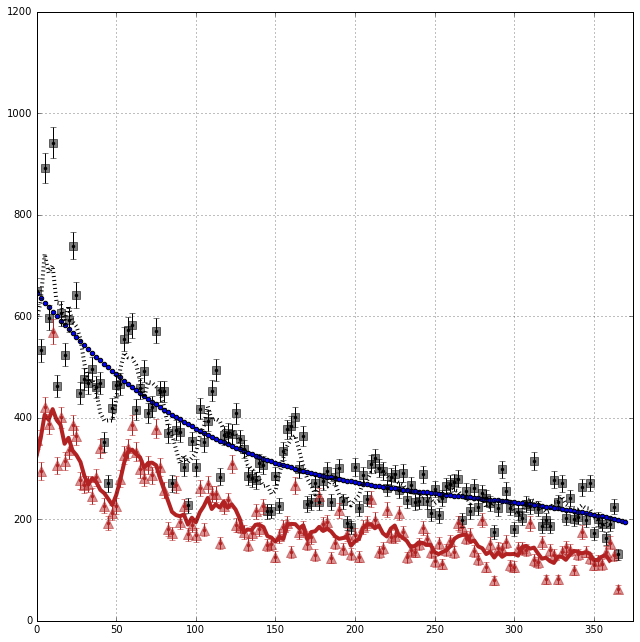

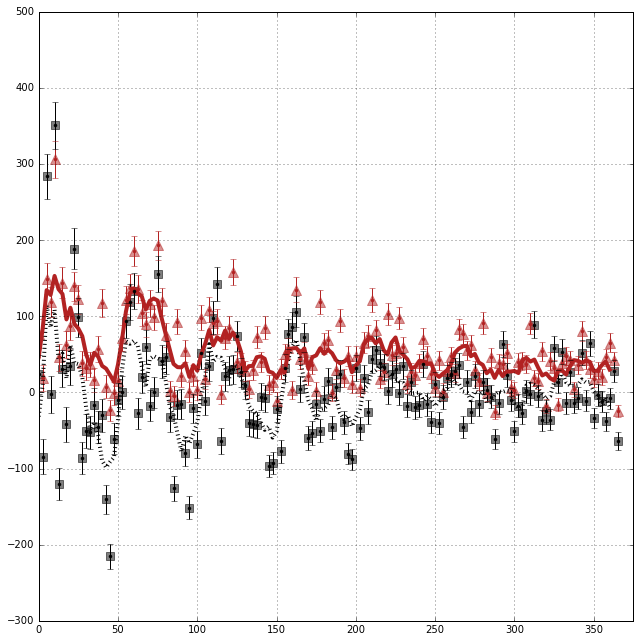

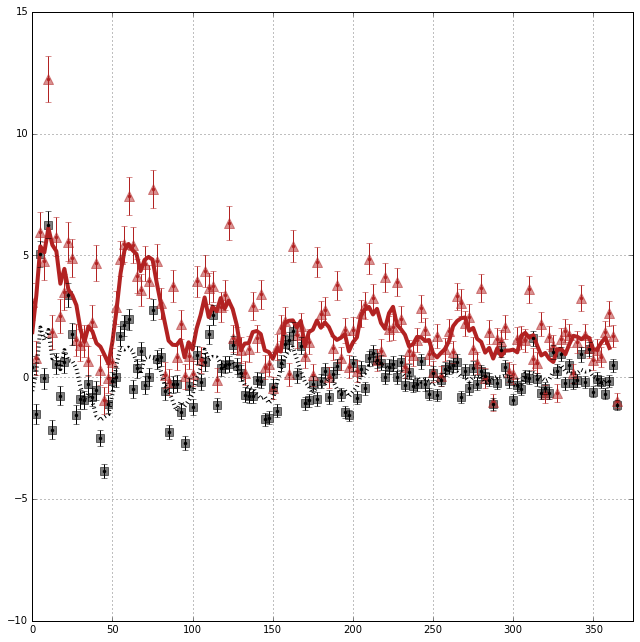

In [84]:
#Raw plot
dataFull = np.add.reduceat(SignalF[2], np.arange(0, len(SignalF[15]), 5))
dataFullB = np.add.reduceat(BackGF[2], np.arange(0, len(BackGF[15]), 5))
times    = np.arange(0,len(dataFull))*2.5

K=5
Atime = running_mean(times,K)
Adat  = running_mean(dataFull,K)
AdatB = running_mean(dataFullB,K)

fig, ax = plt.subplots(figsize=(9,9))

b1 = ax.scatter(times-5,dataFullB, color='k',marker='s',label='Background', alpha=0.5,s=75)
bf1 = ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

s1 = ax.scatter(times-5,dataFull,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
sf1 = ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)

valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 3)
ffitF  = poly.polyval(valsF, coefsF)
plt.scatter(valsF,ffitF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)
ax.errorbar(times-5,dataFull,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataFullB,yerr=naerry,color='k',fmt='.')

ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#Subtracted plot
fig, ax = plt.subplots(figsize=(9,9))

dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)

ax.scatter(times-5,dataSubB, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB,yerr=naerry,color='k',fmt='.')



ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#per pixel plot

fig, ax = plt.subplots(figsize=(9,9))

bknorm=56
signorm=25

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')




ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()

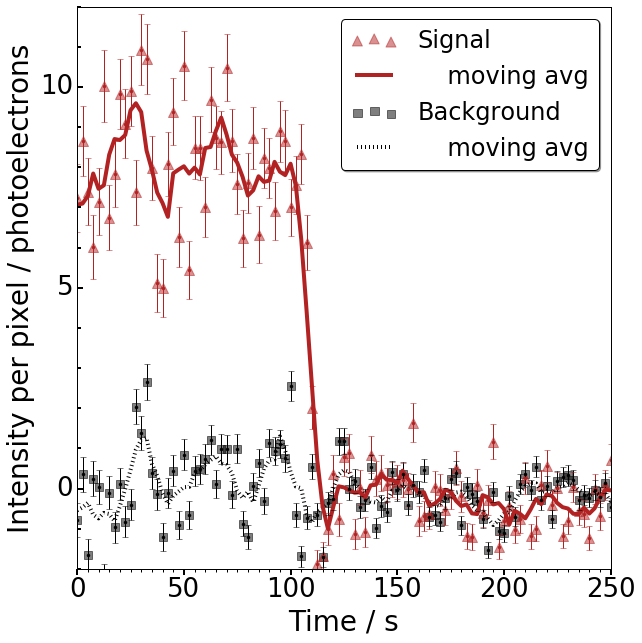

In [10]:
#per pixel plot

dataFull = np.add.reduceat(SignalF[15], np.arange(0, len(SignalF[15]), 5))#[a:b]
dataFullB = np.add.reduceat(BackGF[15], np.arange(0, len(BackGF[15]), 5))
times    = np.arange(0,len(dataFull))*2.5

K=5
Atime = running_mean(times,K)
Adat  = running_mean(dataFull,K)
AdatB = running_mean(dataFullB,K)


valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 3)
ffitF  = poly.polyval(valsF, coefsF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)

dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)


fig, ax = plt.subplots(figsize=(9,9))

bknorm=56
signorm=25
#plt.axhline(0,linewidth=1,color='black',linestyle='-')

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')



ax.set_xlabel(r'Time / s', fontsize=28)
ax.set_ylabel('Intensity per pixel / photoelectrons', fontsize=28)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[2], handles[0]]
aa = '\n   25 pixels'
bb = '\n   56 pixels'

labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(handles,labels,fontsize=24,shadow=True, fancybox=True)

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 260, 50)
xminor_ticks = np.arange(0, 250, 5)
ymajor_ticks = np.arange(0, 20, 5)
yminor_ticks = np.arange(-5, 20, 1)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,250)
ax.set_ylim(-2,12)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/singlebaplots/Ba-Photobleach12.png')
plt.show()